## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

import os
import sys
sys.path.append('../dataset/')

In [4]:
cyclist_df = pd.read_csv(os.path.join('dataset','cyclists.csv'))
races_df = pd.read_csv(os.path.join('dataset','races.csv'))

## Exploration

We begin with a preliminary exploration of the two datasets.

### Cyclists

In [5]:
cyclist_df.shape

(6134, 6)

In [6]:
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [7]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


We can see that there are missing values. Specifically, a lot of cyclists don't have their height and/or weight indicated. 
But first, let's check duplicates.

#### Consistency

Some datatypes have to be converted

In [ ]:
cyclist_df["birth_year"] = pd.to_numeric(cyclist_df["birth_year"], errors='coerce').astype('Int64')

cyclist_df.dtypes

Let's also process the strings

In [ ]:
cyclist_df["name"] = cyclist_df["name"].apply(lambda nome: ' '.join(nome.split()))

#### Duplicates

First, a general check.

In [ ]:
duplicates = cyclist_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


To really find duplicates the values that it makes sense to check are the cyclists' names and identifiers

In [ ]:
cyclist_df[cyclist_df["_url"].duplicated(keep="first")]

No duplicate URLs (i.e. identifiers). There are homonyms though, so one shoud be aware of this.

In [ ]:
cyclist_df[cyclist_df["name"].duplicated(keep=False)]

,_url,name,birth_year,weight,height,nationality
347,andrea-peron-1,Andrea Peron,1971,70.0,183.0,Italy
1745,roman-kreuziger-sr,Roman Kreuziger,1965,NaN,NaN,Czech Republic
2235,alessandro-pozzi2,Alessandro Pozzi,1969,NaN,NaN,Italy
2601,roman-kreuziger,Roman Kreuziger,1986,65.0,183.0,Czech Republic
2682,andrea-peron,Andrea Peron,1988,70.0,178.0,Italy
2862,antonio-cabello-baena,Antonio Cabello,1990,67.0,179.0,Spain
2939,jesus-lopez23,Jesús López,1955,NaN,NaN,Spain
2953,alberto-fernandez-sainz,Alberto Fernández,1981,NaN,NaN,Spain
3238,antonio-cabello,Antonio Cabello,1956,NaN,NaN,Spain
4917,sergio-dominguez-rodriguez,Sergio Domínguez,1979,NaN,NaN,Spain


Upon manual checking, all these cyclists exist, therefore there are no duplicated rows. Let's get back to checking the missing values

#### Missing Data

In [8]:
n_rows = cyclist_df.shape[0]
for col in cyclist_df.columns:
    print(f"There are {n_rows - cyclist_df[col].count()} null values in the {col} column, i.e. {100*(n_rows - cyclist_df[col].count())/n_rows:.2f}% are missing")

There are 0 null values in the _url column, i.e. 0.00% are missing
There are 0 null values in the name column, i.e. 0.00% are missing
There are 13 null values in the birth_year column, i.e. 0.21% are missing
There are 3056 null values in the weight column, i.e. 49.82% are missing
There are 2991 null values in the height column, i.e. 48.76% are missing
There are 1 null values in the nationality column, i.e. 0.02% are missing


Do cyclists that don't have a weight assigned at least have an height, or vice versa?

In [9]:
# Count the number of rows missing both weight and height
missing_weight_height_count = cyclist_df[cyclist_df['weight'].isna() & cyclist_df['height'].isna()].shape[0]
print(f"Number of rows missing both weight and height: {missing_weight_height_count}")
missing_weight_or_height_count = cyclist_df[cyclist_df['weight'].isna() | cyclist_df['height'].isna()].shape[0]
print(f"Number of rows missing either weight or height: {missing_weight_or_height_count}")

Number of rows missing both weight and height: 2984
Number of rows missing either weight or height: 3063


Almost none. This means using a regressor would be critical
Of all these cyclists, how many don't have a weight nor an height nor a birth year?

In [1]:
# .all(axis=1) is basically doing an AND along the columns. So we `.sum()` a Pandas series of length `cyclist_df.shape[0]`
with_no_info = cyclist_df[['birth_year', 'weight', 'height']].isna().all(axis=1)
print(f"There are {with_no_info.sum()} cyclists without birth_year, weight, height")
print("And they are:")
for _, row in cyclist_df[with_no_info].iterrows():
    print(f"_url: {row['_url']:<20} name: {row['name']:<20} nationality: {row['nationality']}")

NameError: name 'cyclist_df' is not defined

### Races

In [ ]:
races_df.shape

In [ ]:
races_df.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


Looks like we don't have to reformat names.

In [ ]:
n_rows = races_df.shape[0]
for col in races_df.columns:
    print(f"There are {n_rows - races_df[col].count()} null values in the {col} column, i.e. {100*(n_rows - races_df[col].count())/n_rows:.2f}% are missing")

There are 0 null values in the _url column, i.e. 0.00% are missing
There are 0 null values in the name column, i.e. 0.00% are missing
There are 477 null values in the points column, i.e. 0.08% are missing
There are 338779 null values in the uci_points column, i.e. 57.43% are missing
There are 0 null values in the length column, i.e. 0.00% are missing
There are 147045 null values in the climb_total column, i.e. 24.93% are missing
There are 148194 null values in the profile column, i.e. 25.12% are missing
There are 0 null values in the startlist_quality column, i.e. 0.00% are missing
There are 559932 null values in the average_temperature column, i.e. 94.93% are missing
There are 0 null values in the date column, i.e. 0.00% are missing
There are 0 null values in the position column, i.e. 0.00% are missing
There are 0 null values in the cyclist column, i.e. 0.00% are missing
There are 113 null values in the cyclist_age column, i.e. 0.02% are missing
There are 0 null values in the is_tarma

In [ ]:
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

In [ ]:
print(f"There are {len(races_df.select_dtypes(include="number").columns)} columns with numeric attributes.")
print(f"\t They are: {[col for col in races_df.select_dtypes(include="number").columns]}\n")
print(f"There are {len(races_df.select_dtypes(exclude="number").columns)} non-numeric attributes.")
print(f"\t They are: {[col for col in races_df.select_dtypes(exclude="number")]}")

There are 10 columns with numeric attributes.
	 They are: ['points', 'uci_points', 'length', 'climb_total', 'profile', 'startlist_quality', 'average_temperature', 'position', 'cyclist_age', 'delta']

There are 8 non-numeric attributes.
	 They are: ['_url', 'name', 'date', 'cyclist', 'is_tarmac', 'is_cobbled', 'is_gravel', 'cyclist_team']


Uci points are assigned to less than half of the performances.
Average temperature is almost nonexistent in the dataset.
Before delving into more accurate analysis the data, let's check its consistency

#### Consistency checks

Let's check the naming convention

In [ ]:
pattern = r"([a-z0-9-]+)/\d{4}/(prologue|result|stage-\d)"
all(races_df['_url'].apply(lambda url: bool(re.match(pattern,url))))

: 

All URLs can be described with this pattern... it'd be nice to have the stage as a different attribute.

In [ ]:
def extract_name_stage(url:str,
              pattern:str=r"([a-z0-9-]+)/\d{4}/(prologue|result|stage-\d)") -> str:
    match = re.match(pattern,url)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    else:
        return None


races_df_copy = pd.DataFrame.copy(races_df)

races_df["name_stage"] = races_df_copy["_url"].apply(extract_name_stage)

: 

With this, our exploration can be more insightful!

Aside the straightforward considerations, `delta` seems to be set everywhere. Is it true or is it just all zeros?

In [ ]:
tot_zero_delta = races_df[(races_df['position'] > 0) & (races_df['delta'] == 0)].shape[0]
print('Number of records with position > 0 and delta = 0', tot_zero_delta)
print(f'Percentage of times delta was not recorded: {tot_zero_delta / races_df.shape[0] * 100:.2f}%')

A lot of $0.0$. We cannot be sure if these are just NaNs under disguise or if the calculations/conversions the delta faced to come into this dataset were just not precise enough. During a photo-finish, we usually encounter deltas that go well under the first decimal digit. <br>
What about the `is_x` attribute? First, we aggregate over the stages and get its unique values for each group

In [ ]:
terrain_grouped_data = races_df.groupby('name_stage').agg({'is_tarmac': 'unique',
                                                                'is_cobbled': 'unique',
                                                                'is_gravel': 'unique'})
terrain_grouped_data

Now, let us also look if the `is_x` attribute has analogous problems to `delta`.

In [ ]:
tot_unsigned_terrain = terrain_grouped_data[
    (terrain_grouped_data['is_tarmac'] == False) & 
    (terrain_grouped_data['is_cobbled'] == False) &
    (terrain_grouped_data['is_gravel'] == False)
    ].shape[0]
print('Total of times terrain was not recorded', tot_unsigned_terrain)
print(f'Percentage of times terrain was not recorded: {tot_unsigned_terrain / races_df.shape[0] * 100:.2f}%')

tot_mixed_terrain = terrain_grouped_data[
    (
        (terrain_grouped_data['is_gravel'] == True) +
        (terrain_grouped_data['is_tarmac'] == True) +
        (terrain_grouped_data['is_cobbled'] == True)
    ) > 1
    ].shape[0]
print('Total of times mixed terrain was recorded', tot_mixed_terrain)
print(f'Percentage of times mixed terrain was recorded: {tot_mixed_terrain / terrain_grouped_data.shape[0] * 100:.2f}%')

As it looks like, there are no races with mixed terrain and some races have no terrain recorded. This may indicate that either the races were ran over another type of terrain, not indicated by the actual attributes, or that there was an error in recording them. Let's see how they are distributed. 

In [ ]:
def count_n_terrains(terrain:str) -> int:
    try:
        n = terrain_grouped_data[f'is_{terrain}'].apply(lambda lista: lista[0]).sum()
        return n
    except KeyError:
        print(f"terrain value {terrain} is invalid.")
        print("Only options are 'tarmac', 'cobbled', 'gravel'")

for terrain in ['tarmac', 'cobbled','gravel']:
    print(f'Out of {terrain_grouped_data.shape[0]} (unique) "atomic competitions", {count_n_terrains(terrain)} have {terrain}')

...Did we miss something?

In [ ]:
for terrain in ['tarmac', 'cobbled','gravel']:
    n = races_df[f'is_{terrain}'].sum()
    print(f"In the big dataframe, out of {races_df.shape[0]}, {n} have {terrain}")

In the big dataframe, out of 589865, 536042 have tarmac
In the big dataframe, out of 589865, 0 have cobbled
In the big dataframe, out of 589865, 0 have gravel


#### Duplicates

Are all the races distinct?

In [ ]:
race_names = np.sort(races_df['name'].unique())
for race in race_names:
    print(race)

: 

Upon a first look, there a lot of suspected duplicates. With the `check_if_same` function we can check if two slightly different names actually correspond to the same race, by comparing the first part of the associated `_url` 

In [ ]:
# Initialize a list to store pairs of races that are actually the same
same_races = []

# Iterate through all pairs of race names
for i in range(len(race_names)):
    for j in range(i + 1, len(race_names)):
        race1 = race_names[i]
        race2 = race_names[j]
        # Use the check_if_same function to compare the races
        try:
            same = check_if_same(race1, race2)[0]
            if same:
                same_races.append((race1, race2))
        except TypeError:
            print(f"Caught error at races {race_names[i]} and {race_names[j]}")
        

# Print the pairs of races that are actually the same
for race1, race2 in same_races:
    print(f"The races '{race1}' and '{race2}' are actually the same.")

In [ ]:
print(f"Allegedly, there are {len(same_races)/2} races that are the same, out of {len(race_names)} possible")

It looks like many races are the same, but they changed name between years. To have the confirmation, one should check the data more carefully considering multiple sources, of course.

In [ ]:
races_df.groupby("name")['_url'].unique()#.iloc[1]

name
Amstel Gold Race                      [amstel-gold-race/2018/result, amstel-gold-rac...
Clasica Ciclista San Sebastian        [san-sebastian/2016/result, san-sebastian/2006...
Clásica Ciclista San Sebastian                              [san-sebastian/2017/result]
Clásica Ciclista San Sebastián        [san-sebastian/2019/result, san-sebastian/1990...
Clásica San Sebastián                 [san-sebastian/1981/result, san-sebastian/1982...
                                                            ...                        
Vuelta Ciclista al País Vasco         [itzulia-basque-country/2012/stage-1, itzulia-...
Vuelta a España                       [vuelta-a-espana/2016/stage-14, vuelta-a-espan...
Vuelta al País Vasco                  [itzulia-basque-country/2007/stage-3, itzulia-...
World Championships - Road Race       [world-championship/1996/result, world-champio...
World Championships ME - Road Race    [world-championship/2002/result, world-champio...
Name: _url, Length: 61, dty

Indeed, for different urls, they are signed with different (although very similar) names albeit being the same race.

#### Missing Data

We noted that Uci points are assigned to less than half of the performances and average temperature is almost nonexistent in the dataset.

In [ ]:
n_rows = races_df.shape[0]
for col in races_df.columns:
    print(f"There are {n_rows - races_df[col].count()} null values in the {col} column, i.e. {100*(n_rows - races_df[col].count())/n_rows:.2f}% are missing")

: 

Missing values are quite a lot. Maybe some can be integrated from other sources. Who knows...

# Analysis

How many unique races are there?

In [ ]:
print(f"Number of unique races: {races_df.shape[0]}")

: 

Let's see if all the cyclist ages are defined at "race time" or are static

In [ ]:
terrain_grouped_data.groupby(['cyclist','cyclist_age']).size()

cyclist           cyclist_age
aad-van-den-hoek  24.0            1
                  25.0            1
                  26.0            1
                  27.0           24
                  28.0            1
                                 ..
zoran-klemencic   24.0           14
                  25.0           14
                  26.0           34
                  28.0           14
zsolt-der         27.0            1
Length: 29871, dtype: int64

How about the profiles? Remember: it's a categorical value indicating increasing difficulty: flat, hilly, mountainous, high mountains

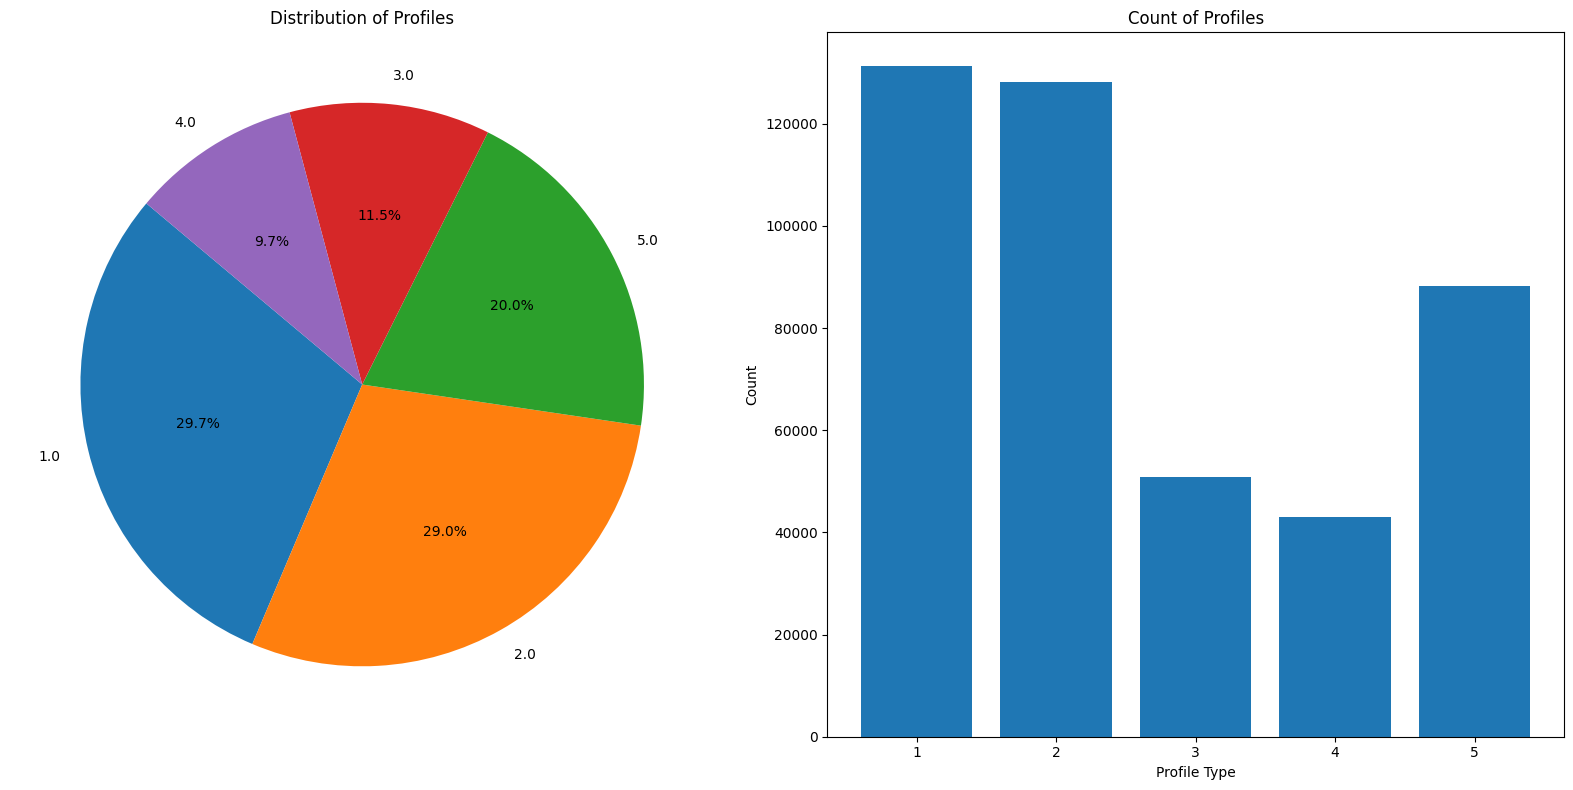

In [ ]:
import matplotlib.pyplot as plt

# Drop rows with NaN values in 'profile' column
dt_cyclism_profile = cyclist_df.dropna(subset=['profile'])

# Count the occurrences of each profile type
profile_counts = dt_cyclism_profile['profile'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the pie chart
axs[0].pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Profiles')

# Plot the bar chart
axs[1].bar(profile_counts.index, profile_counts.values)
axs[1].set_title('Count of Profiles')
axs[1].set_xlabel('Profile Type')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Weird! A fifth *secret* profile. Let's check the average temperature

In [ ]:
# Drop rows with NaN values in 'average_temperature' column
dt_cyclism_temp = cyclist_df.dropna(subset=['average_temperature'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(dt_cyclism_temp['average_temperature'], bins=25, edgecolor='black')
plt.title('Distribution of Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.show()

Are these Kelvin? Probably not. Fahrenheit? No way. It's surely Celsius. <br>
Is there a correlation between these two distributions? Let's make a scatter plot 

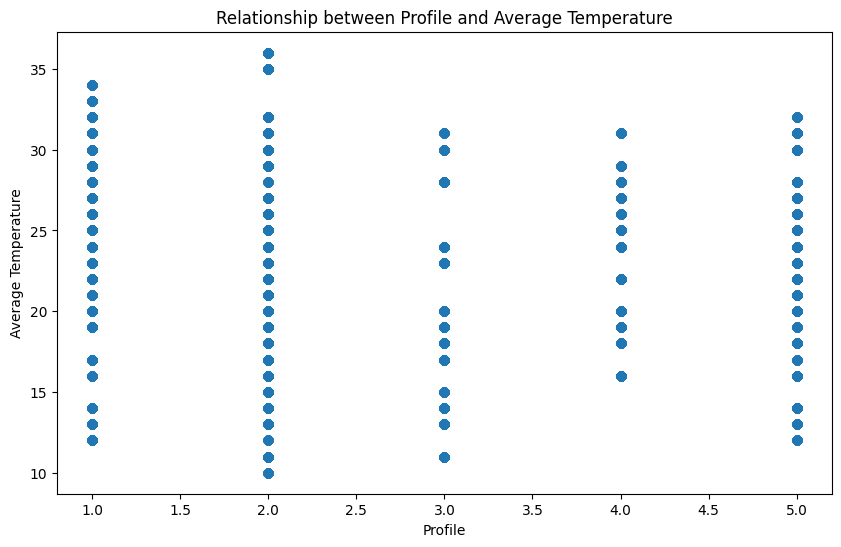

In [ ]:
# Drop rows with NaN values in 'profile' and 'average_temperature' columns
dt_cyclism_profile_temp = cyclist_df.dropna(subset=['profile', 'average_temperature'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dt_cyclism_profile_temp['profile'], dt_cyclism_profile_temp['average_temperature'], alpha=0.5)
plt.title('Relationship between Profile and Average Temperature')
plt.xlabel('Profile')
plt.ylabel('Average Temperature')
plt.show()

Looks like not. Weird, we expected a higher terrain would mean lower average temperatures. <br>
Let's check how the points are distributed.

In [ ]:
dt_points = pd.DataFrame.copy(races_df)
dt_points = dt_points[['name_stage', 'points']]
print(dt_points.shape)
print(dt_points.head())